# Take the filter pack information and add add information for analysis
Inlcudes adding tranmission functions of null and filter regions
This should be redone for every setup change

In [2]:
import numpy as np
from scipy.special import kv
from XANES2020_code.Betatron_analysis import xray_analysis as xray

from XANES2020_code.Betatron_analysis import XcomWebsiteServer as xcom
import pandas as pd
from scipy.io import loadmat
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pickle, os
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import seaborn as sns

from XANES2020_code import PKG_DATA
from XANES2020_code.paths import CAL_DATA

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as fid:
        return pickle.load(fid)
filter_details = pd.read_csv(os.path.join(PKG_DATA,'betatron',
                        'filter_packs/TFAB-D-0017_prelim.csv'))
filter_arangement = np.array(pd.read_csv(os.path.join(PKG_DATA,'betatron',
                        'filter_packs/TFAB-D-0017_arangement.csv'),header=None))

def imagesc(I,ax = None,  x=None, y=None, **kwargs):
    """ display image with axes using pyplot
    recreates matlab imagesc functionality (roughly)
    argument I = 2D numpy array for plotting
    kwargs:
        ax = axes to plot on, if None will make a new one
        x = horizontal  axis - just uses first an last values to set extent
        y = vetical axis like x
        **kwargs anthing else which is passed to imshow except extent and aspec which are set
    """
    if ax is None:
        plt.figure()
        ax = plt.axes()
    if x is None:
        Nx = np.size(I, axis=1)
        x = np.arange(Nx)
    if y is None:
        Ny = np.size(I, axis=0)
        y = np.arange(Ny)
    ext = (x[0], x[-1], y[-1], y[0])
    return ax.imshow(I, extent=ext, aspect='auto', **kwargs)

## load QE of relevant camera

In [5]:

# A_QE = loadmat(os.path.join(PKG_DATA,'betatron','cam_QEs/Lundatron_QE_modelled.mat'),squeeze_me=True,struct_as_record=False)
# A_QE = A_QE['andorQE']

andorQE_filepath = os.path.join(PKG_DATA,'betatron',r'cam_QEs/Gematron_QE_modelled.pkl')

andor_gematron_QE = load_object(andorQE_filepath)

# {
#     'E_keV': E_keV_lin,
#     'QE':  1-cam_scint.T_E
# }


## get mu and rho of filter materials and calculate transmission functions

In [6]:
# data directory with mu files
muPath = os.path.join(PKG_DATA,'betatron','xcom_muFiles')
rhoPath = os.path.join(PKG_DATA,'betatron','xcom_gpcc')

# energy axis for interpolation
nE = 1000
E_keV_lin = np.linspace(1,100,nE)


cam_QE = interp1d(andor_gematron_QE['E_keV'],
                  andor_gematron_QE['QE'])(E_keV_lin)

fRegions = xray.fRegions
fList = []
for index, row in filter_details.iterrows():
    fList.append(fRegions(label=row['filter number'],
                          material = row['Material'],
                          d =  row['Thickness_actual'],
                          dErr = row['Error_actual'],
                          E_keV = E_keV_lin
                         ))
nF = len(fList)
for n in range(0,nF):
    try:
        mu = xcom.loadMuFile(fList[n].material,muPath,E_keV_lin*1e-3)
    except:
        # this bit uses automated website access to get xcom data
        mu, _ = xcom.saveMu2file('el',fList[n].material,E_keV_lin*1e-3,muPath)
#         saveMu2file(materialType,name,Eaxis_MeV,dirPath)
    fList[n].E_keV = E_keV_lin
    fList[n].mu = mu
    fList[n].rho = xcom.getDensity(fList[n].material,rhoPath)
    fList[n].calcT_E()
   



## get mu and rho of null region materials and calculate transmission functions

In [7]:

nullMatType = ['com','el','com','com',];
# nullThickness_micron = (3*6, 3*90e-3,5,180)
nullList = [
        fRegions(label=1,material ='Mylar', d =27.6),
        fRegions(label=2,material ='Al', d =4*12),
        fRegions(label=3,material ='Air', d =85e3),
#         fRegions(label=4,material ='Be', d =250),
        fRegions(label=4,material ='C35H28N2O7', d =150-25+100),
];

nN = len(nullList)
for n in range(0,nN):
    nullList[n].dErr = nullList[n].d*0.15;
    try:
        mu = xcom.loadMuFile(nullList[n].material,muPath,E_keV_lin*1e-3)
    except:
        mu, _ = xcom.saveMu2file(nullMatType[n],nullList[n].material,E_keV_lin*1e-3,muPath)
    nullList[n].E_keV = E_keV_lin
    nullList[n].mu = mu
    nullList[n].rho = xcom.getDensity(nullList[n].material,rhoPath)
    nullList[n].calcT_E()

## Plot functions

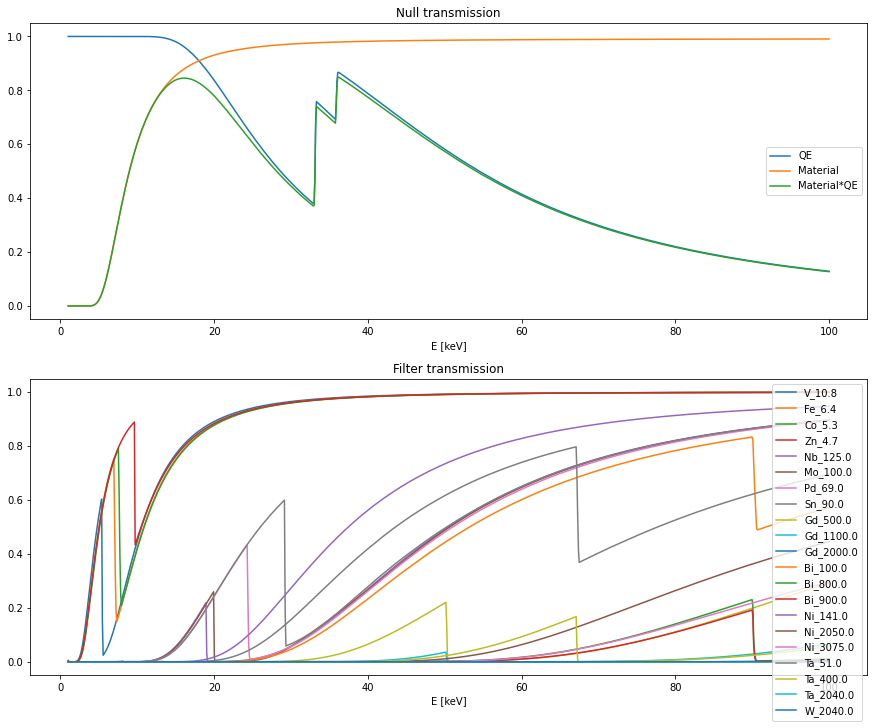

In [8]:
transMat = np.zeros((nE,nF))
for n in range(0,nF):
    transMat[:,n] =  np.exp(-fList[n].rho*fList[n].mu*fList[n].d*1e-4)

nullTrans = np.ones((nE))
for row in nullList:
    nullTrans = nullTrans*np.exp(-row.rho*row.mu*row.d*1e-4)

fig,axs=plt.subplots(2,1,figsize=(15,12))

axs[0].plot(E_keV_lin,cam_QE,label='QE')
axs[0].plot(E_keV_lin,nullTrans,label='Material');
axs[0].plot(E_keV_lin,nullTrans*cam_QE,label='Material*QE');
axs[0].legend()
axs[0].set_title('Null transmission')
for n in range(0,nF):
    axs[1].plot(E_keV_lin,transMat[:,n] ,label=fList[n].material+'_'+f'{fList[n].d}');
axs[1].legend()
axs[1].set_title('Filter transmission')
for ax in axs:
    ax.set_xlabel(r'E [keV]')
#plt.xlim((1,100))

## Assign materials to filter squares

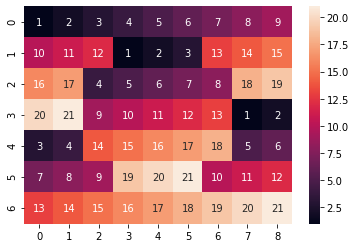

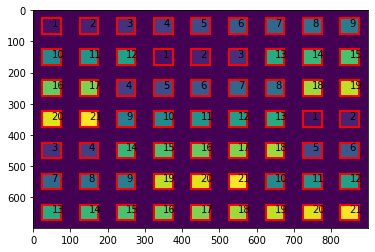

In [9]:

sns.heatmap(filter_arangement, annot=True, fmt="d")
Ny,Nx = np.shape(filter_arangement)

filter_square = np.pad(np.ones((50,50)),((25,25),(25,25)),mode='constant',constant_values=0)
fake_image = np.tile(filter_square,(Ny,Nx))
fake_labels = label(fake_image,background=0,connectivity=2)

fake_regions = regionprops(fake_labels)

fake_filters = np.zeros_like(fake_labels)
for n,region in enumerate(fake_regions):
    fake_filters[fake_labels==region.label] = filter_arangement.flatten()[n]

plt.figure()
ax = plt.axes()
ih = imagesc(fake_filters,ax=ax)

for n,region in enumerate(fake_regions):
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.text(region.centroid[1],region.centroid[0],str(filter_arangement.flatten()[n]))
    ax.add_patch(rect)

### Obtain synthetic transmission image to aid alignment

In [10]:

x = np.logspace(-5,2,num=1000,endpoint=True)
y = (x*kv(2/3,x))**2
f = interp1d(x,y,bounds_error=False,fill_value=0)


def theoretical_trans(E_c):
    S=1.0*f(E_keV_lin/(2*E_c))
    S = S/np.sum(S)
    #null_integrand = E*S*QE*Null_Transmission
    null_integrand = S*cam_QE*nullTrans
    
    integrand = null_integrand[:,np.newaxis] * transMat
    betatron_signal = np.sum(integrand,axis=0)
    null_signal = np.sum(null_integrand,axis=0)

    total_signal = betatron_signal/null_signal
    return total_signal

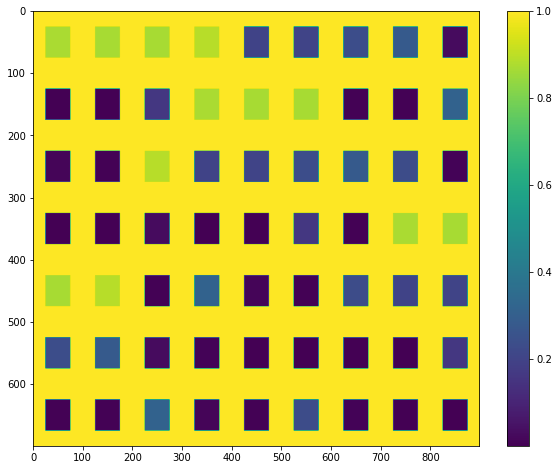

In [11]:
fake_trans = np.zeros_like(fake_filters)
trans_sig = theoretical_trans(20)

for n in range(len(trans_sig)):   
    fake_trans = fake_trans+(fake_filters==(n+1))*trans_sig[n]
fake_trans = fake_trans + 1*(fake_filters<1)
plt.figure(figsize=(10,8))
ax = plt.axes()
ih=imagesc(fake_trans,ax=ax)
cb = plt.colorbar(ih,ax=ax)


## Save transmission functions and arrangement as run specfic object

In [12]:
trans_funcs = []
trans_funcs.append(xray.Trans('camQE', E_keV_lin,cam_QE))
trans_funcs.append(xray.Trans('nullTrans', E_keV_lin, nullTrans))
trans_funcs.append(xray.Trans('filterTrans', E_keV_lin, transMat))

filter_obj = {
    'transmission_functions': trans_funcs,
    'filter_arrangement': filter_arangement,
    'synthetic_filters': fake_filters,
    'synthetic_transmission': fake_trans,
    'filter_fRegions': fList,
    'null_fRegions': nullList,
}
run_name_pref = '20200929_run01_shot001'
save_folder = os.path.join(CAL_DATA,'Gematron')
save_file_path = os.path.join(save_folder,
                              'Gematron_filter_pack_'+run_name_pref+'.pkl')
save_object(filter_obj,save_file_path)



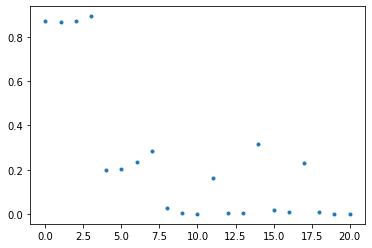

In [13]:
plt.plot(trans_sig,'.')

In [11]:
n=19
print(fList[n].material)
print(fList[n].d)
print(fList[n].label)

Ta
2040.0
20


In [12]:
n=20
print(fList[n].material)
print(fList[n].d)
print(fList[n].label)

W
2040.0
21


In [13]:
trans_sig

array([8.71180477e-01, 8.67348868e-01, 8.69282084e-01, 8.92442927e-01,
       1.98531653e-01, 2.03232704e-01, 2.35000153e-01, 2.83386272e-01,
       2.87777475e-02, 2.43127923e-03, 9.92349270e-05, 1.60804152e-01,
       5.43932765e-03, 3.94919139e-03, 3.12162244e-01, 1.53884880e-02,
       6.42212592e-03, 2.29646274e-01, 8.83493710e-03, 1.07249053e-06,
       3.00620984e-07])